# Project 4 - Part 2 - Full Facial Keypoints Detection


In [1]:
import math
import random
import numpy as np
import pandas as pd
import glob
import scipy
import skimage
import skimage.io as skio
from skimage.transform import resize
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

### Define torch dataset, dataloader for immface


In [2]:
class IMMFaceDataset(Dataset):
    def __init__(self, root_dir, resize_res = [150, 150], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.resize_res = resize_res
        self.img_paths = glob.glob(self.root_dir + '*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, keypoints_relative = self.read_danes_img_and_keypoints(self.img_paths[idx])

        sample = {'image': img, 'keypoints': keypoints_relative}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def read_danes_img_and_keypoints(self, img_path):
        img = skio.imread(img_path, as_gray=True)
        img = resize(img, output_shape=self.resize_res)
        #img = np.reshape(img, (1,self.resize_res[0],self.resize_res[1]))
        img = img.astype(np.float32) - 0.5

        img_filename = os.path.splitext(os.path.basename(img_path))[0]
        asf_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.asf')
        df = pd.read_csv(asf_path, header=None, skiprows=16, nrows=58, delimiter='\t')
        keypoints_relative = df[[2,3]]

        return img, np.array(keypoints_relative, dtype=np.float32)

## Define augmentations

In [3]:
class Face_ToTensor(object):
    def __call__(self, sample):
        new_sample = {'image':  transforms.ToTensor()(sample['image']),
                      'keypoints': sample['keypoints']}
        return new_sample

class Face_ColorJitter(object):
    def __init__(self, **kwargs):
        self.color_jitter_args = kwargs

    def __call__(self, sample):
        new_img = transforms.ColorJitter(**self.color_jitter_args)(transforms.ToPILImage()(((sample['image']+0.5)*255).astype(np.uint8)))
        new_arr = ((np.asarray(new_img)/255) - 0.5).astype('float32')
        new_sample = {'image': new_arr,
                      'keypoints': sample['keypoints']}
        return new_sample

class Face_Shift(object):
    def __init__(self, p=1, min_x=0, min_y=0, max_x=10, max_y=10):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.p = p

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.p:
            x_shift_val = random.choice([-1,1])*random.uniform(self.min_x, self.max_x)
            y_shift_val = random.choice([-1,1])*random.uniform(self.min_y, self.max_y)
            image = scipy.ndimage.shift(image, [y_shift_val, x_shift_val], mode='reflect')
            keypoints[:,0]+=x_shift_val/image.shape[0]
            keypoints[:,1]+=y_shift_val/image.shape[1]
        return {'image': image,
                'keypoints': keypoints}

class Face_Rotate(object):
    def __init__(self, theta=15, p=1):
        # Theta is max angle in degrees to rotate by
        self.theta = theta
        self.p = p

    def rotate_keypoints(self, angle, keypoints, pivot_pt=0.5):
        # Pivot pt is 0.5 because keypoints are [0,1]
        # Rotation matrix
        radians = math.radians(angle)
        R = np.array([
            [np.cos(radians),  np.sin(radians)],
            [-np.sin(radians), np.cos(radians)]
        ])
        return ((R @ (keypoints - pivot_pt).T) + pivot_pt).T

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.p:
            rotate_angle = random.choice([-1,1])*random.uniform(0, self.theta)
            image = skimage.transform.rotate(image, angle=rotate_angle, mode='reflect', preserve_range=True)
            image = image.astype('float32')
            keypoints = self.rotate_keypoints(rotate_angle, keypoints).astype('float32')
        return {'image': image,
                'keypoints': keypoints}

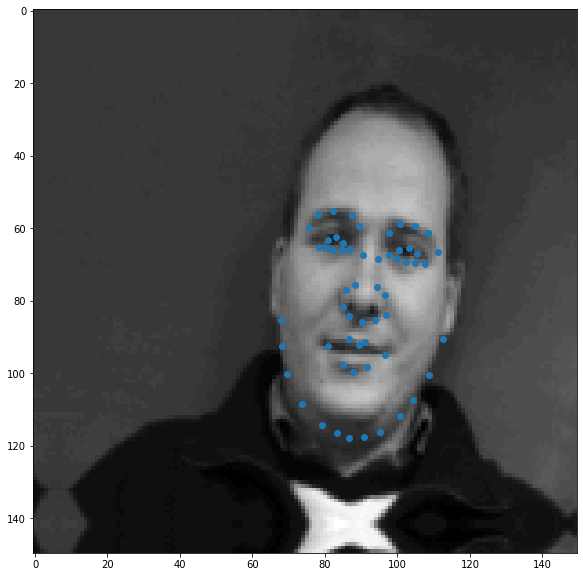

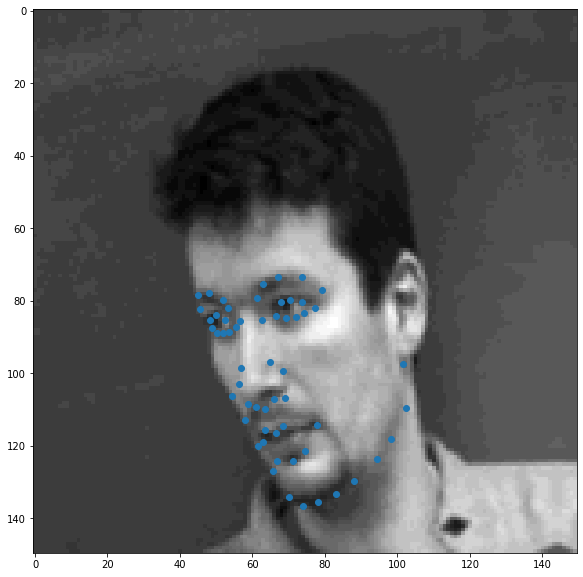

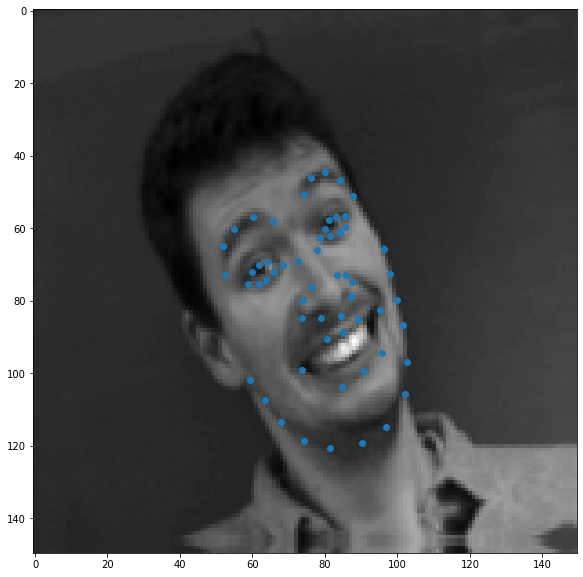

In [4]:
# Test dataset and augmentations
trf = transforms.Compose([Face_Rotate(theta=20),
                          Face_Shift(),
                          Face_ColorJitter(brightness=[0.2,1], contrast=[0.2,1], saturation=[0.2,1], hue=[-0.5,0.5])])
ds = IMMFaceDataset(root_dir='imm_face_db/', transform=trf)

for i in [0,1,2]:
    sample = ds[i]
    img, kps = sample['image'], sample['keypoints']
    plt.figure(figsize=[10,10])
    plt.imshow((img+0.5), cmap='gray')
    plt.scatter(x=kps[:,0]*img.shape[1], y=kps[:,1]*img.shape[0])
    #plt.savefig(f'out_part2/aug_{i}.jpg', bbox_inches='tight')

# Create CNN


In [5]:
class Net(nn.Module):

    def __init__(self, output_size = 58*2):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 7, padding=1)
        self.conv2 = nn.Conv2d(12, 16, 7, padding=1)
        self.conv3 = nn.Conv2d(16, 24, 5, padding=1)
        self.conv4 = nn.Conv2d(24, 32, 5, padding=1)
        self.conv5 = nn.Conv2d(32, 40, 3, padding=1)
        self.conv6 = nn.Conv2d(40, 48, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(48, 512)
        self.fc2 = nn.Linear(512, output_size)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv6(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net().to(dev)
# Define loss and optimizer

In [6]:
print(net)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=48, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=116, bias=True)
)


In [7]:
trf_train = transforms.Compose([
                          Face_Rotate(theta=20),
                          Face_Shift(),
                          Face_ColorJitter(brightness=[0.2,1], contrast=[0.2,1], saturation=[0.2,1], hue=[-0.5,0.5]),
                          Face_ToTensor()])
trf_val = transforms.Compose([Face_ToTensor()])
ds_train = IMMFaceDataset(root_dir='imm_face_db/', transform=trf_train)
ds_val = IMMFaceDataset(root_dir='imm_face_db/', transform=trf_val)

train_dataset = torch.utils.data.Subset(ds_train, range(0,192))
val_dataset = torch.utils.data.Subset(ds_val, range(192,len(ds_val)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2)

In [8]:
def get_loss(net, loader):
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(loader):
            inputs, labels = data['image'], data['keypoints']
            inputs = inputs.to(dev)
            labels = labels.to(dev)
            labels = labels.reshape([-1,58*2])
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        mean_loss = running_loss/len(loader)
    return mean_loss

In [9]:
train_losses = []
val_losses = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['keypoints']
        inputs = inputs.to(dev)
        labels = labels.to(dev)
        labels = labels.reshape([-1,58*2])
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 0:    # Compute metrics every 5 mini-batches
            print('[Epoch %d, Minibatch %d/%d] loss: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 5))
            running_loss = 0.0

    # Compute loss metrics
    train_loss = get_loss(net, train_loader)
    train_losses.append(train_loss)

    val_loss = get_loss(net, val_loader)
    val_losses.append(val_loss)

    print('Epoch %d done - Train %.3f Val %.3f' % (epoch + 1, train_loss, val_loss))
print('Done')

[Epoch 1, Minibatch 1/24] loss: 0.061
[Epoch 1, Minibatch 6/24] loss: 0.295
[Epoch 1, Minibatch 11/24] loss: 0.290
[Epoch 1, Minibatch 16/24] loss: 0.286
[Epoch 1, Minibatch 21/24] loss: 0.290
Epoch 1 done - Train 0.267 Val 0.258
[Epoch 2, Minibatch 1/24] loss: 0.054
[Epoch 2, Minibatch 6/24] loss: 0.257
[Epoch 2, Minibatch 11/24] loss: 0.239
[Epoch 2, Minibatch 16/24] loss: 0.218
[Epoch 2, Minibatch 21/24] loss: 0.176
Epoch 2 done - Train 0.090 Val 0.102
[Epoch 3, Minibatch 1/24] loss: 0.017
[Epoch 3, Minibatch 6/24] loss: 0.060
[Epoch 3, Minibatch 11/24] loss: 0.051
[Epoch 3, Minibatch 16/24] loss: 0.021
[Epoch 3, Minibatch 21/24] loss: 0.020
Epoch 3 done - Train 0.011 Val 0.012
[Epoch 4, Minibatch 1/24] loss: 0.002
[Epoch 4, Minibatch 6/24] loss: 0.011
[Epoch 4, Minibatch 11/24] loss: 0.011
[Epoch 4, Minibatch 16/24] loss: 0.008
[Epoch 4, Minibatch 21/24] loss: 0.007
Epoch 4 done - Train 0.007 Val 0.009
[Epoch 5, Minibatch 1/24] loss: 0.001
[Epoch 5, Minibatch 6/24] loss: 0.007
[Epo

## Plot loss

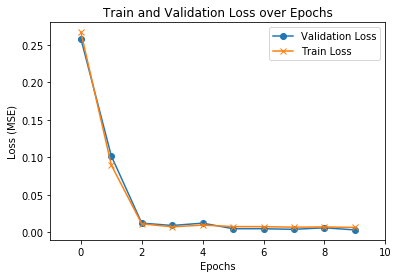

In [10]:
plt.plot(val_losses, marker='o', label='Validation Loss')
plt.plot(train_losses, marker='x', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim([-1,10])
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.savefig('out_part2/loss.png', bbox_inches='tight')

# Try some sample outputs

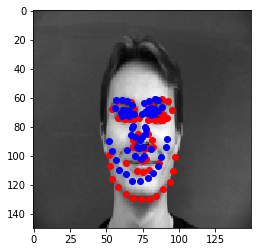

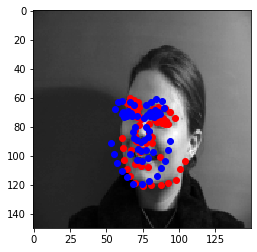

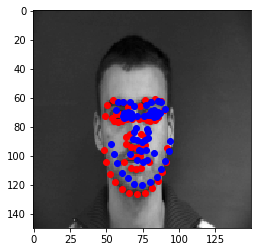

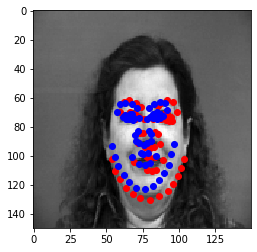

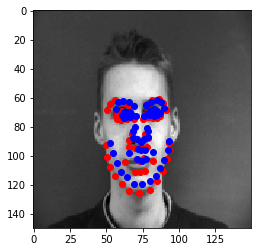

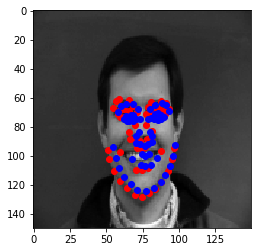

In [13]:
for idx in range(0,6):
    data = next(iter(val_loader))
    with torch.no_grad():
        inputs, labels = data['image'], data['keypoints']
        inputs = inputs.to(dev)
        labels = labels.reshape([-1,58*2])
        out = net(inputs)
    plt.figure()
    img = np.array(inputs.cpu()[idx,0,:,:])
    img = (img+0.5)*255
    plt.imshow(img,cmap='gray')

    # Plot actual kps
    true_kps = np.array(labels.reshape([-1,58,2]))
    plt.scatter(x=true_kps[idx,:,0]*img.shape[1], y=true_kps[idx,:,1]*img.shape[0], color='red')

    # Plot predicted kps
    pred_kps = np.array(out.cpu().reshape([-1,58,2]))
    plt.scatter(x=pred_kps[idx,:,0]*img.shape[1], y=pred_kps[idx,:,1]*img.shape[0], color='blue')
    #plt.savefig(f'out_part2/pred_{idx}.jpg', bbox_inches='tight')

## Visualize filters


In [51]:
def visualize_layers(net, layer_name='conv1', viz_rows=8):
    tensor = getattr(net, layer_name).weight.data.clone()
    tensor = tensor[:,0,:,:].unsqueeze(dim=1)
    grid = utils.make_grid(tensor, nrow=viz_rows, normalize=True, padding=1)
    plt.figure(figsize=(viz_rows,min((tensor.shape[0] // viz_rows + 1, 64))))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(f'Layer {layer_name} filters')

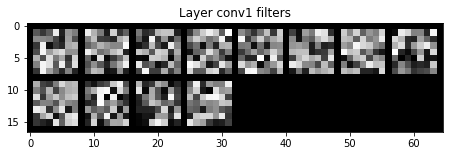

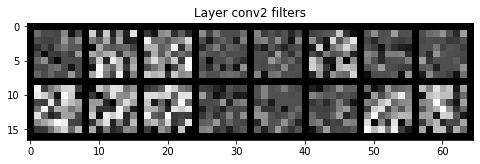

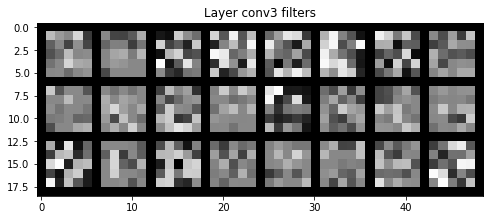

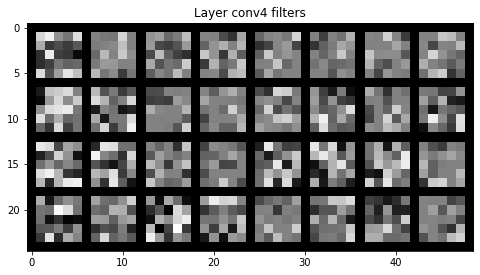

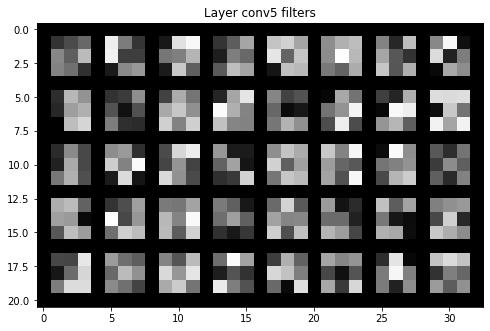

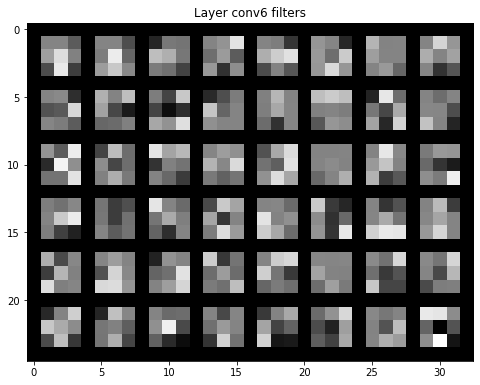

In [53]:
layers_to_viz = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6']
for l in layers_to_viz:
    visualize_layers(net, layer_name=l)
    plt.savefig(f'out_part2/layer_{l}.jpg', bbox_inches='tight')